In [2]:
!pip install mglearn

  Running setup.py bdist_wheel for mglearn: started
  Running setup.py bdist_wheel for mglearn: finished with status 'done'
  Stored in directory: C:\Users\soknu\AppData\Local\pip\Cache\wheels\74\cf\8d\04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn


In [10]:
# Totally inspired by: 
#   https://datascience.stackexchange.com/questions/26678/k-means-program-in-python-for-large-excel-database
#   Müller and Guido, Introduction to Machine Learning with Python, O'Reilly (2017)
#   https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

### IMPORTS
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() #for plot styling
import numpy as np
import pandas as pd
import mglearn
import math

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as gasmix
from sklearn.model_selection import StratifiedKFold

#from numpy import arange
#from sklearn.decomposition import PCA
#import plotly as pl
#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode


#df = pd.read_excel(filename, sheetname=0, parse_cols='B:D', index_col=0, header=[0,1])

#xls = "Engelsberger_short.xlsx"
#datasheet = pd.read_excel(xls)
data = pd.read_excel('Engelsberger_short.xlsx', skiprows = 0, header = 1)
data = data.drop(columns=['Accession (AGI code)', 'Sequence with modifications', 'treatment'])

In [11]:

#Replaces NaN values in rows with something
data.fillna(data.mean(), inplace=True)
#Checks for NaN in data
data.isna().sum()
data.shape


(640, 5)

In [12]:
X=data.iloc[:, 0:5].values

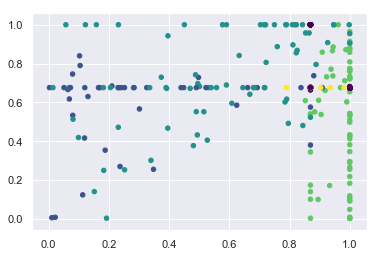

In [13]:
gmm = gasmix(n_components=5).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 20, cmap='viridis');

In [14]:
#GMM is a probabilistic model. What is the probability of any point belonging to a given cluster?
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    1.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.641 0.359 0.   ]
 [0.    0.    0.002 0.998 0.   ]
 [0.    0.    0.108 0.892 0.   ]]


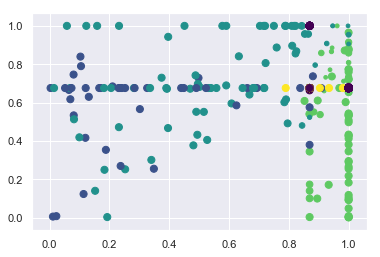

In [15]:
size = 50 * probs.max(1) ** 2 #square emphasizes diffrences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [16]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(data)
data.shape

(640, 5)

In [17]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
        """Draw an ellipse with a given position and covariance"""
        ax = ax or plt.gca()

        # Convert covariance to principal axes
        if covariance.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covariance)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        else:
            angle = 0
            width = 2 * np.sqrt(covariance[0])
            height = 2 * np.sqrt(covariance[1])

        # Draw the Ellipse
        for nsig in range(1, 4):
            for n in range(len(width)):
                nw = nsig * width[n]
                nh = nsig * height[n]
                if math.isnan(nw):
                    nw = 0
                if math.isnan(nh):
                    nh = 0
                ax.add_patch(Ellipse(position, nw, nh, angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


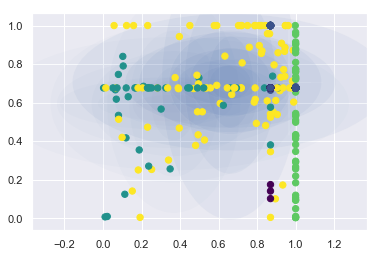

In [18]:
gmm = gasmix(n_components=5, random_state=42)
plot_gmm(gmm, X)

In [19]:
gmm = gasmix(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

NameError: name 'X_stretched' is not defined

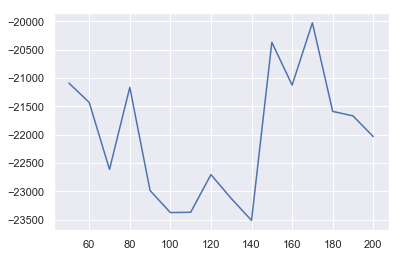

In [20]:
n_components = np.arange(50, 210, 10)
models = [gasmix(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);